In [1]:
epochs = 10

# Part 6 - Federated Learning on MNIST using a CNN

## Upgrade to Federated Learning in 10 Lines of PyTorch + PySyft


### Context 

Federated Learning is a very exciting and upsurging Machine Learning technique that aims at building systems that learn on decentralized data. The idea is that the data remains in the hands of its producer (which is also known as the _worker_), which helps improving privacy and ownership, and the model is shared between workers. One immediate application is for example to predict the next word on your mobile phone when you write text: you don't want the data used for training — i.e. your text messages — to be sent to a central server.

The rise of Federated Learning is therefore tightly connected to the spread of data privacy awareness, and the GDPR in EU which enforces data protection since May 2018 has acted as a catalyst. To anticipate on regulation, large actors like Apple or Google have started investing massively in this technology, especially to protect the mobile users' privacy, but they have not made their tools available. At OpenMined, we believe that anyone willing to conduct a Machine Learning project should be able to implement privacy preserving tools with very little effort. We have built tools for encrypting data in a single line [as mentioned in our blog post](https://blog.openmined.org/training-cnns-using-spdz/) and we now release our Federated Learning framework which leverage the new PyTorch 1.0 version to provide an intuitive interface to building secure and scalable models.

In this tutorial, we'll use directly [the canonical example of training a CNN on MNIST using PyTorch](https://github.com/pytorch/examples/blob/master/mnist/main.py) and show how simple it is to implement Federated Learning with it using our [PySyft library](https://github.com/OpenMined/PySyft/). We will go through each part of the example and underline the code which is changed.

You can also find this material in [our blogpost](https://blog.openmined.org/upgrade-to-federated-learning-in-10-lines).

Authors:
- Théo Ryffel - GitHub: [@LaRiffle](https://github.com/LaRiffle)

**Ok, let's get started!**

### Imports and model specifications

First we make the official imports

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

And than those specific to PySyft. In particular we define remote workers `alice` and `bob`.

In [130]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

We define the setting of the learning task

In [131]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = epochs
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

### Data loading and sending to workers
We first load the data and transform the training Dataset into a Federated Dataset split across the workers using the `.federate` method. This federated dataset is now given to a Federated DataLoader. The test dataset remains unchanged.

In [132]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [208]:
(data, target) = next(iter(federated_train_loader))

In [209]:
target.dtype

torch.float32

In [210]:
fed_mnist = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])).federate((bob, alice))

In [234]:
fed_mnist['alice'][0][1]

(Wrapper)>[PointerTensor | me:16013750933 -> alice:81864895463]

In [135]:
ds = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [193]:
def get_data_at(idx):
    data = torch.stack([ds[i][0] for i in idx])
    target = torch.Tensor(np.stack([ds[i][1] for i in idx]))
    return data, target


In [195]:
n_clients = 2
clients = (bob, alice)
res = np.concatenate([np.where(ds.targets == i)[0] for i in range(10)])
res = res.reshape(2*n_clients, -1)
np.random.shuffle(res)
indices = [res[i:i+2,].flatten() for i in range(0, 2*n_clients, 2)]

dss = []
for idx, c in zip(indices, clients):
    data, target = get_data_at(idx)
    dss.append(sy.BaseDataset(data.send(c), target.send(c)))
# dss = [sy.BaseDataset(ds.data[idx].view(-1, 1, 28, 28).send(c), ds.targets[idx].send(c)) for idx, c in zip(indices, clients)]

# def get

# for i in range(0, n_clients, 2):
#     idx = res[i:i+1,].flatten()
#     sds = sy.BaseDataset(ds.data[idx], ds.targets[idx])

In [235]:
idx = indices[0]
data = torch.stack([ds[i][0] for i in idx])
target = torch.Tensor(np.stack([ds[i][1] for i in idx]))

In [241]:
ds.targets[idx]

tensor([7, 7, 7,  ..., 7, 7, 7])

In [196]:
federated_train_dataset = sy.FederatedDataset(dss)

In [197]:
dl = sy.FederatedDataLoader(federated_train_dataset)

In [204]:
i, t = next(iter(dl))

In [206]:
t.dtype

torch.float32

In [157]:
ds.data[idx].view(-1, 1, 28, 28).shape

torch.Size([300, 1, 28, 28])

In [127]:
federated_train_dataset

FederatedDataset
    Distributed accross: bob, alice
    Number of datapoints: 60000

tensor(4)


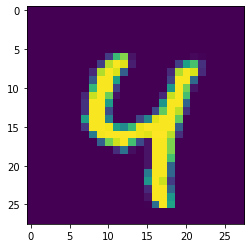

In [108]:
datasets[0][0]
print(datasets[0][30][1])
plt.imshow(datasets[0][30][0])

In [94]:
idx = res[0:1,].flatten()
sds = sy.BaseDataset(ds.data[idx], ds.targets[idx])

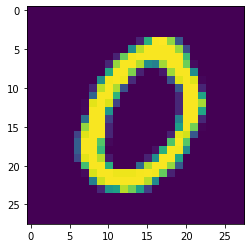

In [93]:
import matplotlib.pyplot as plt
plt.imshow(sds[0][0])

In [73]:
tmp = np.arange(30).reshape(-1, 10)
np.random.shuffle(tmp)
tmp

array([[10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [75]:
list(range(0,10,2))

[0, 2, 4, 6, 8]

In [25]:
img, y = next(iter(ds))

In [27]:
for i, (_, y) in enumerate(ds):
    print(y)
    if i > 20:
        break

5
0
4
1
9
2
1
3
1
4
3
5
3
6
1
7
2
8
6
9
4
0


### CNN specification
Here we use exactly the same CNN as in the official example.

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Define the train and test functions
For the train function, because the data batches are distributed across `alice` and `bob`, you need to send the model to the right location for each batch. Then, you perform all the operations remotely with the same syntax like you're doing local PyTorch. When you're done, you get back the model updated and the loss to look for improvement.

In [18]:
def train(args, model, device, federated_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get() # <-- NEW: get the model back
        if batch_idx % args.log_interval == 0:
            loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))

The test function does not change!

In [19]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Launch the training !

In [ ]:
%%time
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(), "mnist_cnn.pt")



Et voilà! Here you are, you have trained a model on remote data using Federated Learning!

## One Last Thing
I know there's a question you're dying to ask: **how long does it takes to do Federated Learning compared to normal PyTorch?**

The computation time is actually **less than twice the time** used for normal PyTorch execution! More precisely, it takes 1.9 times longer, which is very little compared to the features we were able to add.

## Conclusion

As you observe, we modified 10 lines of code to upgrade the official Pytorch example on MNIST to a real Federated Learning setting!

Of course, there are dozen of improvements we could think of. We would like the computation to operate in parallel on the workers and to perform federated averaging, to update the central model every `n` batches only, to reduce the number of messages we use to communicate between workers, etc. These are features we're working on to make Federated Learning ready for a production environment and we'll write about them as soon as they are released!

You should now be able to do Federated Learning by yourself! If you enjoyed this and would like to join the movement toward privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways! 

### Star PySyft on GitHub

The easiest way to help our community is just by starring the repositories! This helps raise awareness of the cool tools we're building.

- [Star PySyft](https://github.com/OpenMined/PySyft)

### Pick our tutorials on GitHub!

We made really nice tutorials to get a better understanding of what Federated and Privacy-Preserving Learning should look like and how we are building the bricks for this to happen.

- [Checkout the PySyft tutorials](https://github.com/OpenMined/PySyft/tree/master/examples/tutorials)


### Join our Slack!

The best way to keep up to date on the latest advancements is to join our community! 

- [Join slack.openmined.org](http://slack.openmined.org)

### Join a Code Project!

The best way to contribute to our community is to become a code contributor! If you want to start "one off" mini-projects, you can go to PySyft GitHub Issues page and search for issues marked `Good First Issue`.

- [Good First Issue Tickets](https://github.com/OpenMined/PySyft/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)

### Donate

If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

- [Donate through OpenMined's Open Collective Page](https://opencollective.com/openmined)